In [1]:
from IPython.display import Image

# CNTK 103: Part B - Логический регрессионный анализ с MNIST

Мы предполагаем, что вы успешно завершили CNTK 103 Part A.

В этом уроке мы будем строить и обучать модель мультиномиальной логистической регрессии с использованием данных MNIST. Этот ноутбук предлагает рецепт с использованием API Python. Если вы ищете этот пример в BrainScript, посмотрите [здесь](https://github.com/Microsoft/CNTK/tree/release/2.2/Examples/Image/GettingStarted)

## Введение


**Проблема**:
Optical Character Recognition (OCR) это исследование актуальной области, и существует большой спрос на её автоматизацию. Данные MNIST состоят из рукописных цифр с небольшим фоновым шумом, что делает его отличным набором данных для создания, экспериментирования и изучения моделей глубокого обучения с достаточно небольшими вычислительными ресурсами.

In [2]:
# Рисунок 1
Image(url= "http://3.bp.blogspot.com/_UpN7DfJA0j4/TJtUBWPk0SI/AAAAAAAAABY/oWPMtmqJn3k/s1600/mnist_originals.png", width=200, height=200)

**Цель**:
Наша цель - подготовить классификатор, который будет идентифицировать цифры в наборе данных MNIST. 

**Подход**:
Используются те же 5 этапов, которые мы использовали в предыдущем учебнике: чтение данных, предварительная обработка данных, создание модели, изучение параметров модели и оценка (тестирование / прогнозирование) модели.
- Чтение данных: мы будем использовать CNTK Text reader 
- Предварительная обработка данных: включена в часть A (suggested extension section). 

Остальные шаги идентичны CNTK 102. 

## Логический регрессионный анализ
[Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) (LR) это фундаментальный метод машинного обучения, который использует линейную взвешенную комбинацию признаков и генерирует прогнозы на основе вероятности разных классов.  
​
Существуют две основные формы LR: **Binary LR** (с одним выходом, который может предсказать два класса) и **multinomial LR** (с несколькими выходами, каждый из которых используется для прогнозирования одного класса).  

![](http://www.cntk.ai/jup/cntk103b_TwoFormsOfLR-v3.png)

В **Binary Logistic Regression** (см. Выше на рисунке выше) функции ввода масштабируются соответствующим весом и суммируются вместе.  Сумма передается через функцию сжатия (aka activation) и генерирует выход в [0,1].  Это выходное значение (которое можно рассматривать как вероятность) затем сравнивается с пороговым значением (например, 0,5) для создания двоичной метки (0 или 1).  Этот метод поддерживает только проблемы классификации с двумя выходными классами, называется двоичный LR.  В примере двоичного LR, показанном выше, функция [sigmoid][] используется как функция сжатия.

[sigmoid]: https://en.wikipedia.org/wiki/Sigmoid_function

В **Multinomial Linear Regression** (см. Нижнюю часть рисунка выше), используются 2 или более выходных узла, по одному для каждого класса выпуска, который должен быть предсказан. Каждый узел суммирования использует свой собственный набор весов для масштабирования входных функций и суммирования их. Вместо того, чтобы передавать суммированный вывод взвешенных входных признаков через функцию сигмовидного сжатия, выход часто пропускается через функцию [softmax][] (которая в дополнение к раздавливанию, подобно сигмоиду, softmax нормализует выходное значение каждого узла, используя сумму всех ненормализованных узлов). (Подробности в контексте изображения MNIST)

В этом руководстве мы будем использовать многокомпонентную LR для классификации MNIST-цифр (0-9) с использованием 10 выходных узлов (по 1 для каждого из наших выходных классов).

[softmax]: https://en.wikipedia.org/wiki/Softmax_function

In [3]:
# Загрузка необходимых компонентов
from __future__ import print_function # Используйте определение функции из будущей версии (скажем 3.x из 2.7 interpreter)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (требуется только для нашей системы сборки)
C.cntk_py.set_fixed_random_seed(1) # перемешаем, чтобы примеры LR не повторялись

%matplotlib inline

## Инициализация

In [4]:
# Определение сети
input_dim = 784
num_output_classes = 10

## Чтение данных

В этом уроке мы используем данные MNIST, которые вы загрузили, используя ноутбук CNTK_103A_MNIST_DataLoader. Набор данных содержит 60 000 обучающих изображений и 10 000 тестовых изображений, каждое изображение которых составляет 28 х 28 пикселей. Таким образом, количество функций равно 784 (= 28 x 28 пикселей), 1 на пиксель. Переменная  `num_output_classes` установлена в 10, соответствующая количеству цифр (0-9) в наборе данных.

Данные находятся в следующем формате:

    |labels 0 0 0 1 0 0 0 0 0 0 |features 0 0 0 0 ... 
                                                  (784 integers each representing a pixel)
    
В этом уроке мы будем использовать пиксели изображения, соответствующие целочисленному потоку с именем "features".  Мы определяем функцию  `create_reader` для чтения данных обучения и тестирования с помощью [CTF deserializer](https://cntk.ai/pythondocs/cntk.io.html?highlight=ctfdeserializer#cntk.io.CTFDeserializer). Метки [1-hot encoded](https://en.wikipedia.org/wiki/One-hot). Обратитесь к учебнику CNTK 103A для визуализации формата данных. 

In [5]:
# Прочтите текст в формате CTF (как упоминалось выше), используя десериализатор CTF из файла
def create_reader(path, is_training, input_dim, num_label_classes):
    
    labelStream = C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False)
    featureStream = C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)
    
    deserailizer = C.io.CTFDeserializer(path, C.io.StreamDefs(labels = labelStream, features = featureStream))
            
    return C.io.MinibatchSource(deserailizer,
       randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [6]:
# Убедитесь, что данные обучения и тестирования созданы и доступны для этого учебника.
# Мы выполняем поиск в двух местах в наборе инструментов для кэшированного набора данных MNIST.
data_found = False

for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                 os.path.join("data", "MNIST")]:
    train_file = os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    test_file = os.path.join(data_dir, "Test-28x28_cntk_text.txt")
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found = True
        break
        
if not data_found:
    raise ValueError("Please generate the data by completing CNTK 103 Part A")
    
print("Data directory is {0}".format(data_dir))

Data directory is data\MNIST


## Создание модели

Сеть логистической регрессии (LR) представляет собой простой строительный блок, который эффективно задействовал многие ML
приложений за последнее десятилетие. На следующем рисунке представлена модель в контексте данных MNIST.

![](https://www.cntk.ai/jup/cntk103b_MNIST_LR.png)

LR представляет собой простую линейную модель, которая принимает в качестве входных данных вектор чисел, описывающих свойства того, что мы классифицируем (также известный как вектор-функция, $\bf \vec{x}$, пиксели на цифровом изображении ввода MNIST) и ивыводит  *evidence* ($z$). Для каждой из 10 цифр имеется вектор весов, соответствующий входным пикселям, как показано на рисунке. Эти 10 весовых векторов определяют весовую матрицу ($\bf {W}$) с размером 10 х 784. Каждая особенность во входном слое связана с узлом суммирования на соответствующий вес $w$ (индивидуальные значения веса из $\bf{W}$ матрицы). Обратите внимание, что существует 10 таких узлов, каждый из которых соответствует каждой цифре. 

Первый шаг - вычислить доказательства для наблюдения.

$$\vec{z} = \textbf{W} \bf \vec{x}^T + \vec{b}$$ 

где $\bf{W}$ - весовая матрица размерности 10 x 784, а $\vec{b}$ известна как вектор  *bias* с длиной 10, по одной для каждой цифры. 

Доказательства ($\vec{z}$) не зажата (следовательно, нет активации). Вместо этого выход нормализуется с помощью функции [softmax](https://en.wikipedia.org/wiki/Softmax_function) , так что все выходы суммируются до значения 1, тем самым предоставляя вероятностную итерацию предсказанию. В CNTK мы используем операцию softmax которая сочетается с функцией cross entropy error .

Сетевой вход и выход:
- **input** переменная (ключевая концепция CNTK): 
>Переменная ** input ** - это контейнер, в котором мы заполняем различные наблюдения в этом случае пикселями изображения во время обучения модели (a.k.a.training) и оценки модели (a.k.a. testing). Таким образом, форма  `input` must match the shape of the data that will be provided.  должна соответствовать форме данных, которые будут предоставлены. Например, когда данные представляют собой изображения с высотой 10 пикселей и шириной 5 пикселей, размер функции ввода будет равен 50 (что соответствует общему числу пикселей изображения). Подробнее о данных и их размерах можно найти в отдельных учебниках.


**Вопрос** Каков размер ввода выбранной вами модели? Это имеет фундаментальное значение для нашего понимания переменных в представлении сети или модели в CNTK.

In [7]:
input = C.input_variable(input_dim)
label = C.input_variable(num_output_classes)

## Настройка логистической регрессии

Модуль слоев CNTK предоставляет функцию Dense, которая создает полностью подключенный уровень, который выполняет вышеупомянутые операции взвешенного ввода суммирования и смещения.  

In [8]:
def create_model(features):
    with C.layers.default_options(init = C.glorot_uniform()):
        r = C.layers.Dense(num_output_classes, activation = None)(features)
        return r

`z` будет использоваться для представления вывода сети.

In [9]:
# Sвведите значение 0-1, разделив каждый пиксель на 255.
z = create_model(input/255.0)

### Параметры модели обучения

Как и в предыдущем учебнике, мы используем функцию `softmax` для сопоставления накопленных доказательств или активации с распределением вероятности по классам (подробности [softmax function](http://cntk.ai/pythondocs/cntk.ops.html#cntk.ops.softmax) и другие функции [activation](https://cntk.ai/pythondocs/cntk.layers.layers.html#cntk.layers.layers.Activation) ).

## Обучение

Подобно CNTK 102, мы используем минимизацию кросс-энтропии между меткой и прогнозируемой вероятностью сетью. Если эта терминология звучит незнакомо для вас, обратитесь к CNTK 102 для изучения. 

In [10]:
loss = C.cross_entropy_with_softmax(z, label)

### Обучение

Чтобы оценить классификацию, можно сравнить выход сети, который для каждого наблюдения излучает вектор доказательств (может быть преобразован в вероятности с использованием функций `softmax`) с размерностью, равной числу классов. 

In [11]:
label_error = C.classification_error(z, label)

### Настройка обучения

Тренер -"trainer" стремится уменьшить функцию `loss` различными подходами к оптимизации, [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (`sgd`) который является одним из самых популярных. Как правило, можно начинать со случайной инициализации параметров модели. Оптимизатор `sgd` вычислял бы `loss` или ошибку между прогнозируемой меткой против соответствующей метки истины и используя  [gradient-decent](http://www.statisticsviews.com/details/feature/5722691/Getting-to-the-Bottom-of-Regression-with-Gradient-Descent.html) генерирует новые параметры модели набора в одной итерации. 

Вышеупомянутое обновление параметров модели с использованием одного наблюдения за раз привлекательно, поскольку для загрузки в память не требуется весь набор данных (all observation) а также требуется вычисление градиента за меньшее количество данных, что позволяет проводить обучение на больших наборах данных. Тем не менее, обновления, созданные с использованием одного образца наблюдения за раз, могут сильно различаться между итерациями. Промежуточное основание - загрузить небольшой набор наблюдений и использовать среднее значение `loss` ли ошибку из этого набора для обновления параметров модели. Это подмножество называется *minibatch*.

С помощью мини-отсеков мы часто выбираем наблюдение из более крупного набора учебных материалов. Мы повторяем процесс обновления параметров модели с использованием различной комбинации учебных образцов и в течение периода времени минимизируем `loss` (и ошибку). Когда инкрементные частоты ошибок больше не изменяются значительно или после заданного количества максимальных минимумов для тренировки, мы утверждаем, что наша модель обучена.

Один из ключевых параметров [optimization](https://en.wikipedia.org/wiki/Category:Convex_optimization) называется  `learning_rate`. На данный момент мы можем рассматривать его как фактор масштабирования, который модулирует, насколько мы меняем параметры на любой итерации. Мы рассмотрим более подробные сведения в следующем учебном пособии.
С этой информацией мы готовы создать нашего тренера trainer. 

In [12]:
# Создайте экземпляр объекта trainer  для обучения модели
learning_rate = 0.2
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
learner = C.sgd(z.parameters, lr_schedule)
trainer = C.Trainer(z, (loss, label_error), [learner])

Сначала создадим некоторые вспомогательные функции, которые понадобятся для визуализации различных функций, связанных с обучением.

In [13]:
# Определите функцию полезности для вычисления скользящей средней суммы.
# Более эффективная реализация возможна с помощью функции np.cumsum() 
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]    # Нужно отправить копию массива
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Определяет утилиту, которая печатает ход обучения
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error

### Запуск trainer

Теперь мы готовы обучать нашу полностью связанную нейронную сеть. Мы хотим решить, какие данные нам нужны для обучения в учебном движке.

В этом примере каждая итерация оптимизатора будет работать с образцами размером `minibatch_size`.  Мы хотели бы тренироваться во всех 60000 наблюдениях. Кроме того, мы сделаем несколько проходов через данные, заданные переменной `num_sweeps_to_train_with`.  С помощью этих параметров мы можем продолжить обучение нашей простой сети.

In [28]:
# Инициализация параметров для trainer
minibatch_size = 64
num_samples_per_sweep = 60000
num_sweeps_to_train_with = 10
num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size

In [29]:
# Создайте reader для набора данных обучения
reader_train = create_reader(train_file, True, input_dim, num_output_classes)

# Сопоставьте потоки данных со входом и метками
input_map = {
    label  : reader_train.streams.labels,
    input  : reader_train.streams.features
} 

# Запуск trainerи обучение модели
training_progress_output_freq = 500

plotdata = {"batchsize":[], "loss":[], "error":[]}

for i in range(0, int(num_minibatches_to_train)):
    
    # Прочитайте mini batch из файла данных обучения
    data = reader_train.next_minibatch(minibatch_size, input_map = input_map)
    
    trainer.train_minibatch(data)
    batchsize, loss, error = print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
    
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

Minibatch: 0, Loss: 0.1209, Error: 4.69%
Minibatch: 500, Loss: 0.3416, Error: 9.38%
Minibatch: 1000, Loss: 0.1914, Error: 4.69%
Minibatch: 1500, Loss: 0.3332, Error: 12.50%
Minibatch: 2000, Loss: 0.1324, Error: 6.25%
Minibatch: 2500, Loss: 0.1658, Error: 4.69%
Minibatch: 3000, Loss: 0.0827, Error: 1.56%
Minibatch: 3500, Loss: 0.2627, Error: 9.38%
Minibatch: 4000, Loss: 0.3514, Error: 6.25%
Minibatch: 4500, Loss: 0.2312, Error: 6.25%
Minibatch: 5000, Loss: 0.1485, Error: 3.12%
Minibatch: 5500, Loss: 0.1042, Error: 3.12%
Minibatch: 6000, Loss: 0.1252, Error: 3.12%
Minibatch: 6500, Loss: 0.2412, Error: 7.81%
Minibatch: 7000, Loss: 0.1363, Error: 7.81%
Minibatch: 7500, Loss: 0.2782, Error: 7.81%
Minibatch: 8000, Loss: 0.0896, Error: 3.12%
Minibatch: 8500, Loss: 0.1449, Error: 6.25%
Minibatch: 9000, Loss: 0.1024, Error: 3.12%


Построим ошибки над различными обучающими minibatches.  Обратите внимание, что по мере того, как мы повторяем потери при тренировке, мы видим некоторые промежуточные результтаты. 

Следовательно, мы используем более мелкие minibatches, и использование `sgd` позволяет нам иметь большую масштабируемость при выполнении больших наборов данных.

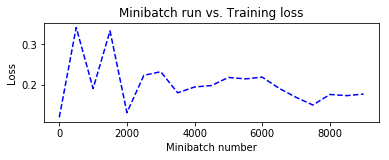

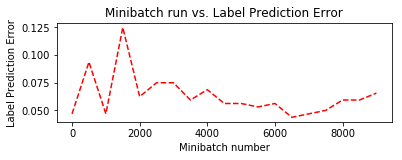

In [30]:
# Вычислить скользящую среднюю потерю, чтобы сгладить шум в SGD
plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

# Визуализируем потерю обучения и ошибку обучения
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')

plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error')
plt.show()

### Оценка выполнения / Тестирование

Теперь, когда мы обучили сеть, давайте оценим подготовленную сеть по тестовым данным. Это делается с помощью `trainer.test_minibatch`.

In [31]:
# Прочтите данные обучения
reader_test = create_reader(test_file, False, input_dim, num_output_classes)

test_input_map = {
    label  : reader_test.streams.labels,
    input  : reader_test.streams.features,
}

# Данные испытаний для обученной модели
test_minibatch_size = 512
num_samples = 10000
num_minibatches_to_test = num_samples // test_minibatch_size
test_result = 0.0

for i in range(num_minibatches_to_test):
    
    # Мы загружаем тестовые данные пакетами, указанными test_minibatch_size
    # Каждая точка данных вminibatch представляет собой изображение цифры MNIST размером 784
    # с одним пикселем на измерение, которое мы будем кодировать / декодировать 
    # с помощью обучаемой модели.
    data = reader_test.next_minibatch(test_minibatch_size,
                                      input_map = test_input_map)

    eval_error = trainer.test_minibatch(data)
    test_result = test_result + eval_error

# Среднее значение evaluation errors всех тестовых minibatches
print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))

Average test error: 7.25%


Обратите внимание: эта ошибка очень сопоставима с нашей ошибкой обучения, указывающей на то, что наша модель имеет хорошую ошибку "out of sample"  a.k.a. generalization error. Это означает, что наша модель может очень эффективно справляться с ранее невидимыми наблюдениями (во время учебного процесса). Это ключ, чтобы избежать явления переобучения.

До сих пор мы имеем дело с совокупными мерами ошибки. Возьмем теперь вероятности, связанные с отдельными точками данных. Для каждого наблюдения функция `eval` возвращает распределение вероятности по всем классам. Классификатор обучается распознавать цифры, поэтому имеет 10 классов. Сначала проложим сетевой выход через функцию  `softmax` . Это сопоставляет агрегированные активации по сети с вероятностями по 10 классам.

In [32]:
out = C.softmax(z)

Обратимся к небольшому minibatch из тестовых данных.

In [33]:
# Прочтите данные для оценки
reader_eval = create_reader(test_file, False, input_dim, num_output_classes)

eval_minibatch_size = 25
eval_input_map = {input: reader_eval.streams.features} 

data = reader_test.next_minibatch(eval_minibatch_size, input_map = test_input_map)

img_label = data[label].asarray()
img_data = data[input].asarray()
predicted_label_prob = [out.eval(img_data[i]) for i in range(len(img_data))]

In [34]:
# Найдите индекс с максимальным значением как для предсказанной, так и для основной истины
pred = [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel = [np.argmax(img_label[i]) for i in range(len(img_label))]

In [35]:
print("Label    :", gtlabel[:25])
print("Predicted:", pred)

Label    : [4, 5, 6, 7, 8, 9, 7, 4, 6, 1, 4, 0, 9, 9, 3, 7, 8, 4, 7, 5, 8, 5, 3, 2, 2]
Predicted: [4, 6, 6, 7, 5, 9, 7, 4, 6, 1, 4, 0, 4, 9, 3, 7, 1, 2, 7, 5, 8, 6, 3, 2, 2]


Давайте визуализируем некоторые результаты

Image Label:  4


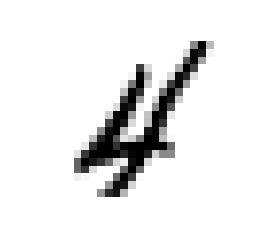

In [37]:
# Визуализируем случайное изображение
sample_number = 10
plt.imshow(img_data[sample_number].reshape(28,28), cmap="gray_r")
plt.axis('off')

img_gt, img_pred = gtlabel[sample_number], pred[sample_number]
print("Image Label: ", img_pred)

**Задание**
-  Попробуйте изучить, как ведет себя классификатор с разными параметрами, например. изменение параметра `minibatch_size` т 25 до 64 или 128. Что происходит с частотой ошибок? Как ошибка сравнивается с логистическим классификатором регрессии?
- Попробуйте увеличить количество эпох
- Попробуйте изменить сеть, чтобы снизить частоту ошибок обучения? Когда происходит *overfitting* переобучение?